In [ ]:
import os
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager
import seaborn as sn
from scipy.stats import zscore
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
sn.set_style("white")

from scipy.spatial import cKDTree

csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':12}

In [ ]:
df = pd.read_csv(r"../data/level1_edm2018.csv",sep=",")
df = df[df['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
df['CODMUNI'] = df['CODMUNI'].astype(str).str.zfill(3)
df['edge_id'] = df['VORIZT1259']+"|"+df['VDESZT1259']
relations = df['edge_id'].unique()
df.drop_duplicates(subset=['ID_HOGAR','ID_IND','ID_VIAJE'],inplace=True)
df = df[df['VDES']!='Casa']
df = df[df['C8ACTIV']!='Otra situación']


In [ ]:
gdf = gpd.read_file(r"../data/ZonificacionZT1259.shp")
gdf = gdf[gdf['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
gdf = gdf.to_crs(25830)

c:\Documents\Github\pw_sources\env\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: ../data/ZonificacionZT1259.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [48]:
hexa = gpd.read_file(r"../data/hexagon_grid.gpkg")
gdf['geometry'] = gdf['geometry'].buffer(0)
hexa = hexa[hexa.intersects(gdf['geometry'].unary_union)]

C:\Users\katul\AppData\Local\Temp\ipykernel_12652\3466312415.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hexa = hexa[hexa.intersects(gdf['geometry'].unary_union)]


In [49]:
datasets = [
r"../data/pois_network_centrality_1500.csv",
r"../data/pois_network_centrality_1200.csv",
r"../data/pois_network_centrality_900.csv",
r"../data/pois_design_1500.csv",
r"../data/pois_design_1200.csv",
r"../data/pois_design_900.csv",
r"../data/pois_other_1500.csv",
r"../data/pois_other_1200.csv",
r"../data/pois_other_900.csv",
r"../data/pois_walkable_trips_1500.csv",
r"../data/pois_walkable_trips_1200.csv",
r"../data/pois_walkable_trips_900.csv",
r"../data/pois_transacc_1500.csv",
r"../data/pois_transacc_1200.csv",
r"../data/pois_transacc_900.csv",
r"../data/pois_parkacc_1500.csv",
r"../data/pois_parkacc_1200.csv",
r"../data/pois_parkacc_900.csv",
r"../data/pois_far_localacc_1500.csv",
r"../data/pois_far_localacc_1200.csv",
r"../data/pois_far_localacc_900.csv"]


In [50]:
data = {d.split("/")[-1].split(".")[0]:pd.read_csv(d) for d in datasets}

In [ ]:
for k,v in data.items():
    data[k] = v[['poi_id']+[c for c in v.columns if not c in ['poi_id','tz_id','local_population','geometry']]]
    

In [52]:
for k,v in data.items():
    if 'pois_parkacc' in k:
        data[k] = pd.concat([v[v['park_type'] == t].set_index('poi_id')['unique_parks_count'].rename(f'acc_parks_{t}') for t in ["S","M","L"]],axis=1)
    else: data[k] = v.set_index('poi_id')


In [53]:
template = pd.read_csv(r"../data/fn_pois_template.csv").set_index('poi_id')

In [54]:
template['geometry'] = template['geometry'].apply(loads)
template = gpd.GeoDataFrame(template, geometry='geometry', crs= 25830)

In [ ]:
cols = ['tz_id', 'node_id', 'local_population', 

'dem_income', 'dem_household_size', 'dem_mean_age',
'dem_population_18', 'dem_population_65',

'acc_care_other','acc_care_public',
'acc_school_superior', 'acc_school_basic',
'acc_leisure_bar', 'acc_leisure_cultural', 'acc_leisure_shows',
'acc_shopping_mall', 'acc_shopping_market', 'acc_shopping_alone',
'acc_sport_other',
'acc_transportation',
'acc_parks_S', 'acc_parks_M', 'acc_parks_L',
'dens_pop_total', 'dens_hou_total',
'dens_far', 'dens_far_ag',
'den_perc_unbuilt', 'dens_built_total',
'den_perc_housing_sfr','den_perc_housing_ch',
'den_perc_care_other', 'den_perc_care_public',
'den_perc_school_superior', 'den_perc_school_basic',
'den_perc_leisure_bar', 'den_perc_leisure_cultural',
'den_perc_leisure_shows', 'den_perc_shopping_mall',
'den_perc_shopping_market', 'den_perc_shopping_alone',
'den_perc_sport_other', 'den_perc_office', 'den_perc_industrial',
'den_perc_storage', 'den_perc_parking', 'den_perc_hotel',
'den_perc_religious', 'den_perc_infra', 

'div_wt_care', 'div_ut_care', 'div_wt_school', 'div_ut_school',
'div_wt_leisure', 'div_ut_leisure', 'div_wt_shopping',
'div_ut_shopping', 'div_wt_sport', 'div_ut_sport', 

'des_mean_degree', 'des_straightness', 
'des_total_length','des_block_length', 'des_culdesac', 'des_slope','des_building_age',
       
'geometry']

In [56]:
btw = gpd.read_file(r"../data/betweenness.gpkg")[['degree','closeness','betweenness','eigenvector','geometry']].rename(columns ={'degree':'des_degree','closeness':'des_closeness','betweenness':'des_betweenness','eigenvector':'des_eigenvector'})

In [57]:
df_900 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "900" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1200 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1200" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1500 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1500" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]

In [58]:
df_300 = df_900[df_900['local_population'] > 0]
df_600 = df_1200[df_1200['local_population'] > 0]
df_900 = df_1500[df_1500['local_population'] > 0]

In [ ]:
def join_by_nearest(gdf1,gdf2):
    gdf1_coords = gdf1.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    gdf2_coords = gdf2.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

    tree_gdf1 = cKDTree(gdf1_coords)
    tree_gdf2 = cKDTree(gdf2_coords)

    distances, indices = tree_gdf1.query(gdf2_coords, k=1)

    valid_indices = [i for i in range(len(indices)) if indices[i] < len(gdf1)]

    results = pd.DataFrame({
        'gdf1_index': [indices[i] for i in valid_indices],
        'gdf2_index': valid_indices,
        'distance': [distances[i] for i in valid_indices]
    })

    gdf1_matched = gdf1.iloc[results['gdf1_index']].reset_index(drop=True)
    gdf2_matched = gdf2.iloc[results['gdf2_index']].reset_index(drop=True)

    return gdf1_matched.join(gdf2_matched, lsuffix='', rsuffix='_gdf2')


In [60]:
df_300 = join_by_nearest(df_300,btw)
df_600 = join_by_nearest(df_600,btw)
df_900 = join_by_nearest(df_900,btw)

Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1


In [61]:
df_300 = df_300.set_crs(25830)
df_600 = df_600.set_crs(25830)
df_900 = df_900.set_crs(25830)

In [62]:
for c in [col for col in df_900.columns if col not in ['geometry', 'node_id', 'tz_id', 'local_population', 'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index']]:
    print("............................")
    print(f"Results on column {c}")
    print(f"Zero values in zones {str(df_900.loc[df_900[c]==0]['tz_id'].unique()).replace(" ",",")}")
    print(f"Negative values in zones {str(df_900.loc[df_900[c]<0]['tz_id'].unique()).replace(" ",",")}")
    print(f"Max value: {df_900[c].max()}")
    print(f"Mean value: {df_900[c].loc[df_900[c]!=0].mean()}")
    print(f"Min value: {df_900[c].loc[df_900[c]!=0].min()}")
    print(df_900.drop_duplicates(subset='node_id').sort_values(by=c,ascending=False)[c].head(10).to_string())
    print(df_900.drop_duplicates(subset='node_id').sort_values(by=c,ascending=True)[c].head(10).to_string())


............................
Results on column dem_income
Zero values in zones []
Negative values in zones []
Max value: 133380.0
Mean value: 58868.02477787124
Min value: 21237.0
62554    133380.0
62555    133380.0
62556    133380.0
62557    133380.0
91958    133380.0
91973    133380.0
91986    133380.0
92026    133380.0
92085    133380.0
92107    133380.0
29990    21237.000000
4987     24059.363963
5157     24130.424427
4988     24136.325291
5154     24204.943851
5092     24219.826028
5117     24229.921729
4989     24254.287419
5091     24290.279374
4998     24291.225528
............................
Results on column dem_household_size
Zero values in zones []
Negative values in zones []
Max value: 3.4000000000000306
Mean value: 2.782311748079319
Min value: 1.9702710466983384
59238    3.4
53799    3.4
55937    3.4
59909    3.4
59910    3.4
58259    3.4
58258    3.4
59907    3.4
59088    3.4
58549    3.4
38416    1.970271
38669    1.971535
38429    1.972595
38671    1.973210
38414    1.

In [63]:
hexa.rename(columns = {'id':'hex_id'}, inplace=True)

In [64]:
def join_to_hexa(df,hexa):
    gdf_hex_joined = gpd.sjoin(df, hexa, how="inner", predicate="intersects")

    if 'hex_id' not in gdf_hex_joined.columns:
        gdf_hex_joined = gdf_hex_joined.rename(columns={'index_right': 'hex_id'})

    gdf_hex_joined = gdf_hex_joined.dropna(subset=['hex_id'])

    columns_to_average = [col for col in gdf_hex_joined.columns if col not in ['geometry', 'node_id', 'tz_id', 'local_population', 'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index']]


    hex_aggregated = gdf_hex_joined.groupby('hex_id')[columns_to_average].mean() 

    return hexa[['hex_id', 'geometry']].merge(hex_aggregated, on='hex_id', how='left')


In [65]:
def agg_tzs(df):
    df = df[df['local_population']!=0]
    columns_to_average = [col for col in df.columns if col not in ['geometry', 'node_id', 'tz_id', 'local_population', 'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index']]
    
    def weighted_average(dfg):
        weights = dfg['local_population']
        return pd.Series({
            col: (dfg[col] * weights).sum() / weights.sum() for col in columns_to_average
        })
    
    df_aggregated = df.groupby('tz_id')[['local_population']+columns_to_average].apply(weighted_average).reset_index()
    
    return df_aggregated


In [66]:
df_tz_300 = agg_tzs(df_300)
df_tz_600 = agg_tzs(df_600)
df_tz_900 = agg_tzs(df_900)

In [67]:
for c in [col for col in df_tz_900.columns if col not in ['geometry', 'node_id', 'tz_id', 'local_population', 'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index']]:
    print("............................")
    print(f"Results on column {c}")
    print(f"Zero values in zones {str(df_tz_900.loc[df_tz_900[c]==0]['tz_id'].unique()).replace(" ",",")}")
    print(f"Negative values in zones {str(df_tz_900.loc[df_tz_900[c]<0]['tz_id'].unique()).replace(" ",",")}")
    print(f"Max value: {df_tz_900[c].max()}")
    print(f"Mean value: {df_tz_900[c].loc[df_tz_900[c]!=0].mean()}")
    print(f"Min value: {df_tz_900[c].loc[df_tz_900[c]!=0].min()}")

............................
Results on column dem_income
Zero values in zones ['005-011B','006-003B','006-008A','006-008B','006-016C','006-017'
,'007-002','022-008','058-029','079-08-142','079-17-491','113-002B'
,'115-013','148-001']
Negative values in zones []
Max value: 133380.0
Mean value: 48773.73814882217
Min value: 4889.784829250256
............................
Results on column dem_household_size
Zero values in zones ['005-011B','006-003B','006-008A','006-008B','006-016C','006-017'
,'007-002','022-008','058-029','079-08-142','079-17-491','113-002B'
,'115-013','148-001']
Negative values in zones []
Max value: 3.364868472467396
Mean value: 2.4507482973149584
Min value: 0.35800611725709286
............................
Results on column dem_mean_age
Zero values in zones ['005-011B','006-003B','006-008A','006-008B','006-016C','006-017'
,'007-002','022-008','058-029','079-08-142','079-17-491','113-002B'
,'115-013','148-001']
Negative values in zones []
Max value: 48.58200937572814
Me

In [68]:
df_300 = join_to_hexa(df_300,hexa)
df_600 = join_to_hexa(df_600,hexa)
df_900 = join_to_hexa(df_900,hexa)

In [69]:
"""
# Supón que df es tu dataframe
def categorize_z_scores(df,cols):
    # Calcula el z-score para cada columna numérica y asegura que el resultado es un DataFrame
    df_z = df.copy()
    for c in cols:
        df_z.loc[df_z[c].notnull(), c] = zscore(df_z[df_z[c].notnull()][c])

    # Define la función de categorización
    def categorize(value):
        if value < -2:
            return 0
        elif -2 <= value < -1:
            return 1
        elif -1 <= value < 1:
            return 2
        elif 1 <= value < 2:
            return 3
        else:
            return 4

    # Aplica la función de categorización a cada valor del z-score
    
    df_categorized = df_z.applymap(lambda x: categorize(x) if isinstance(x, (int, float)) else x)
    return df_categorized
    return df_z"
"""


'\n# Supón que df es tu dataframe\ndef categorize_z_scores(df,cols):\n    # Calcula el z-score para cada columna numérica y asegura que el resultado es un DataFrame\n    df_z = df.copy()\n    for c in cols:\n        df_z.loc[df_z[c].notnull(), c] = zscore(df_z[df_z[c].notnull()][c])\n\n    # Define la función de categorización\n    def categorize(value):\n        if value < -2:\n            return 0\n        elif -2 <= value < -1:\n            return 1\n        elif -1 <= value < 1:\n            return 2\n        elif 1 <= value < 2:\n            return 3\n        else:\n            return 4\n\n    # Aplica la función de categorización a cada valor del z-score\n    \n    df_categorized = df_z.applymap(lambda x: categorize(x) if isinstance(x, (int, float)) else x)\n    return df_categorized\n    return df_z"\n'

In [70]:
def remove_and_transform_outliers(df, columns):
    """
    Removes outliers in the specified columns of the DataFrame and transforms them
    to the maximum non-outlier value in that column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - columns (list): List of column names to process for outliers.
    
    Returns:
    - pd.DataFrame: DataFrame with outliers transformed to the max non-outlier value.
    """
    df_corrected = df.copy()  # Make a copy to avoid modifying the original DataFrame
    
    for col in columns:
        # Calculate Q1, Q3, and IQR for outlier detection
        Q1 = df_corrected[col].quantile(0.25)
        Q3 = df_corrected[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get the maximum value within the non-outlier range
        max_non_outlier_value = df_corrected[(df_corrected[col] >= lower_bound) & (df_corrected[col] <= upper_bound)][col].max()
        
        # Replace outliers with the maximum non-outlier value
        df_corrected.loc[df_corrected[col] > upper_bound, col] = max_non_outlier_value
        df_corrected.loc[df_corrected[col] < lower_bound, col] = max_non_outlier_value
    
    return df_corrected


In [71]:
columns_of_interest = [c for c in df_300.columns if any(sub in c for sub in ["dem","den","div","des","acc"])]

In [72]:
df300c = remove_and_transform_outliers(df_300, ['dem_income','dem_household_size','dem_mean_age'])
df600c = remove_and_transform_outliers(df_600, ['dem_income','dem_household_size','dem_mean_age'])
df900c = remove_and_transform_outliers(df_900, ['dem_income','dem_household_size','dem_mean_age'])


In [73]:
munis = ["28005", "28006", "28007", "28022", "28026", "28045", "28049", "28058", "28065", "28073", "28074", "28080", "28084", "28092", "28104", "28106", "28113", "28115", "28127", "28130", "28134", "28148", "28167", "28176", "28177", "28181", "28903", "28079","28123","28903"]
gdf_ine = gpd.read_file(r"../data/level1_ine_geo_2018.gpkg")
muni_ref = gdf_ine[(gdf_ine['boundary_type'] == "municipality")&(gdf_ine['municipality_code'].isin(munis))]                                                
muni_ref = muni_ref.dissolve()
muni_ref = muni_ref['geometry'].boundary

In [74]:
def make_plot(cax, df, col, map):
    
    cmap = LinearSegmentedColormap.from_list("bry", ["lightgray","lightskyblue", "red"])
    df.plot(column = col,ax = cax, cmap = cmap ,linewidth=0,scheme='natural_breaks')
    muni_ref.plot(linewidth=0.5, ax = cax,color='black',zorder=3)
    cax.set_title(map,**hfont,va="center_baseline")
    cax.yaxis.set_label_text("")
    cax.set_xlabel('') 
    cax.axis('off')

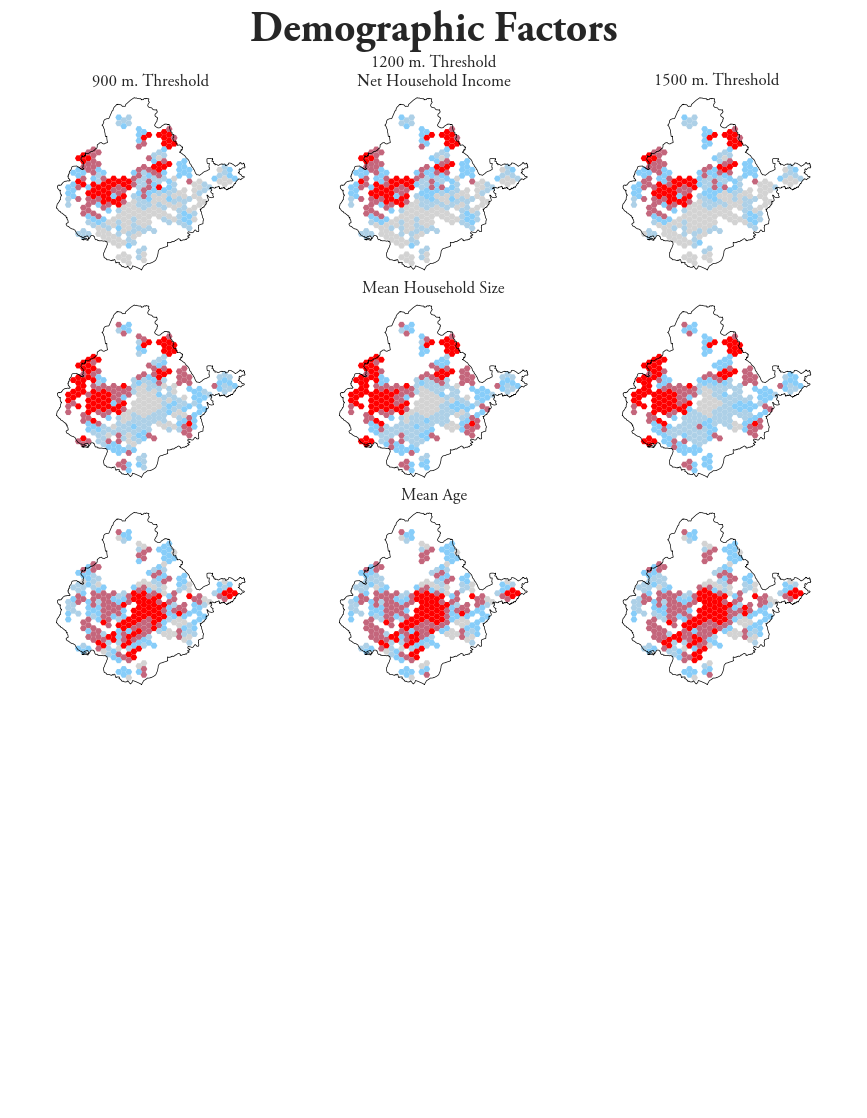

In [75]:
fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('Demographic Factors',**csfont, fontweight="bold",y=1) # Title
make_plot(ax[0][0], df300c[~df300c['dem_income'].isna()], 'dem_income', '900 m. Threshold')
make_plot(ax[0][1], df600c[~df600c['dem_income'].isna()], 'dem_income', '1200 m. Threshold\nNet Household Income')
make_plot(ax[0][2], df900c[~df900c['dem_income'].isna()], 'dem_income', '1500 m. Threshold')

make_plot(ax[1][0], df300c[~df300c['dem_income'].isna()], 'dem_household_size', '')
make_plot(ax[1][1], df600c[~df600c['dem_income'].isna()], 'dem_household_size', 'Mean Household Size')
make_plot(ax[1][2], df900c[~df900c['dem_income'].isna()], 'dem_household_size', '')

make_plot(ax[2][0], df300c[~df300c['dem_mean_age'].isna()], 'dem_mean_age', '')
make_plot(ax[2][1], df600c[~df600c['dem_mean_age'].isna()], 'dem_mean_age', 'Mean Age')
make_plot(ax[2][2], df900c[~df900c['dem_mean_age'].isna()], 'dem_mean_age', '')

for x in (3,4):
    for y in (0,1,2):
        ax[x][y].yaxis.set_label_text("")
        ax[x][y].set_xlabel('') 
        ax[x][y].axis('off')

fig.tight_layout(pad=0.1)
#plt.grid(False)

plt.savefig(r"../figures/demographic_factors_1.jpg")

plt.show()


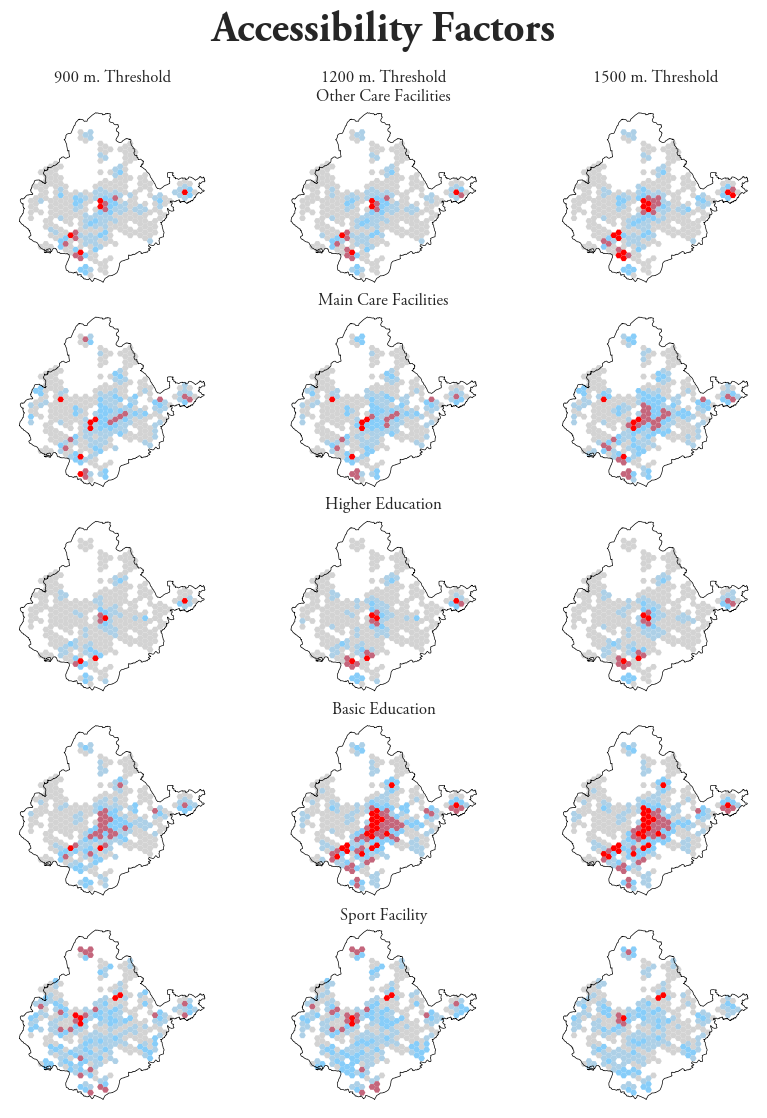

In [76]:
fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('Accessibility Factors',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['acc_care_other'].isna()], 'acc_care_other', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['acc_care_other'].isna()], 'acc_care_other', '1200 m. Threshold\nOther Care Facilities')
make_plot(ax[0][2], df900c[~df900c['acc_care_other'].isna()], 'acc_care_other', '1500 m. Threshold\n')


make_plot(ax[1][0], df300c[~df300c['acc_care_public'].isna()], 'acc_care_public', '')
make_plot(ax[1][1], df600c[~df600c['acc_care_public'].isna()], 'acc_care_public', 'Main Care Facilities')
make_plot(ax[1][2], df900c[~df900c['acc_care_public'].isna()], 'acc_care_public', '')

make_plot(ax[2][0], df300c[~df300c['acc_school_superior'].isna()], 'acc_school_superior', '')
make_plot(ax[2][1], df600c[~df600c['acc_school_superior'].isna()], 'acc_school_superior', 'Higher Education')
make_plot(ax[2][2], df900c[~df900c['acc_school_superior'].isna()], 'acc_school_superior', '')

make_plot(ax[3][0], df300c[~df300c['acc_school_basic'].isna()], 'acc_school_basic', '')
make_plot(ax[3][1], df600c[~df600c['acc_school_basic'].isna()], 'acc_school_basic', 'Basic Education')
make_plot(ax[3][2], df900c[~df900c['acc_school_basic'].isna()], 'acc_school_basic', '')

make_plot(ax[4][0], df300c[~df300c['acc_sport_other'].isna()], 'acc_sport_other', '')
make_plot(ax[4][1], df600c[~df600c['acc_sport_other'].isna()], 'acc_sport_other', 'Sport Facility')
make_plot(ax[4][2], df900c[~df900c['acc_sport_other'].isna()], 'acc_sport_other', '')
#ax[4][0].set_xlabel('300 m. Threshold',**hfont,fontweight='bold') 
#ax[4][1].set_xlabel('600 m. Threshold',**hfont,fontweight='bold') 
#ax[4][2].set_xlabel('900 m. Threshold',**hfont,fontweight='bold') 

fig.tight_layout(pad=0.1)
#plt.grid(False)

plt.savefig(r"../figures/accessibility_factors_1.jpg")

plt.show()

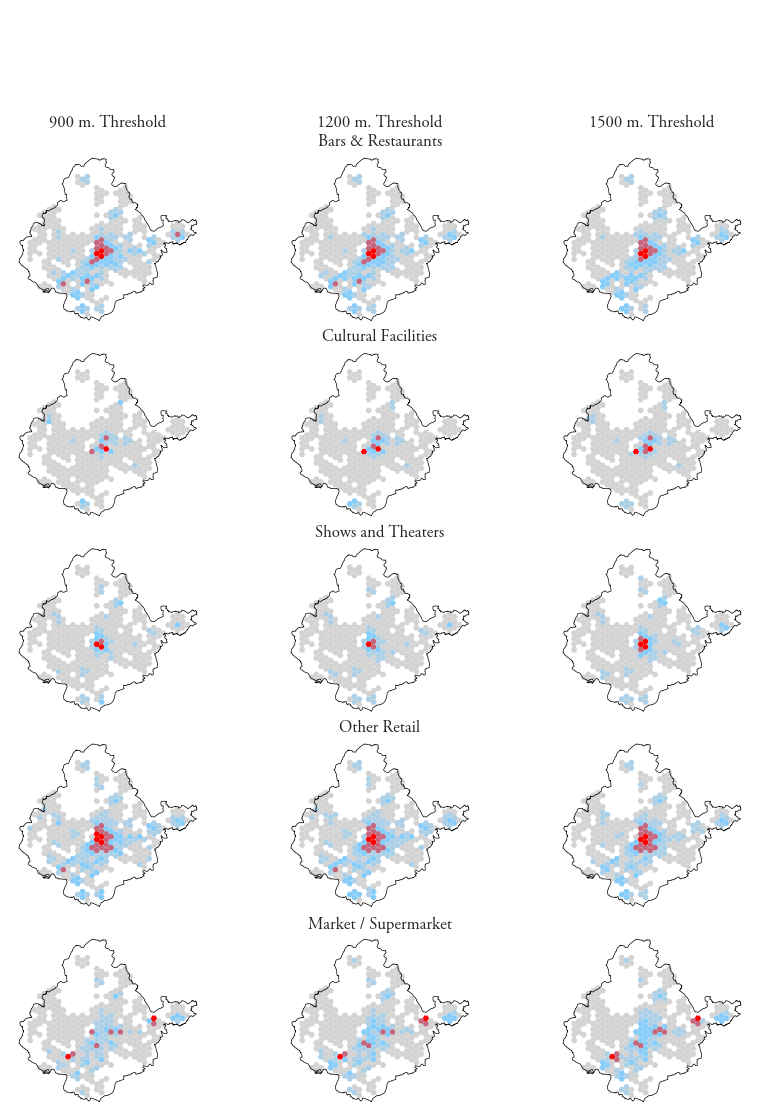

In [77]:
fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title
make_plot(ax[0][0], df300c[~df300c['acc_leisure_bar'].isna()], 'acc_leisure_bar', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['acc_leisure_bar'].isna()], 'acc_leisure_bar', '1200 m. Threshold\nBars & Restaurants')
make_plot(ax[0][2], df900c[~df900c['acc_leisure_bar'].isna()], 'acc_leisure_bar', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['acc_leisure_cultural'].isna()], 'acc_leisure_cultural', '')
make_plot(ax[1][1], df600c[~df600c['acc_leisure_cultural'].isna()], 'acc_leisure_cultural', 'Cultural Facilities')
make_plot(ax[1][2], df900c[~df900c['acc_leisure_cultural'].isna()], 'acc_leisure_cultural', '')

make_plot(ax[2][0], df300c[~df300c['acc_leisure_shows'].isna()], 'acc_leisure_shows', '')
make_plot(ax[2][1], df600c[~df600c['acc_leisure_shows'].isna()], 'acc_leisure_shows', 'Shows and Theaters')
make_plot(ax[2][2], df900c[~df900c['acc_leisure_shows'].isna()], 'acc_leisure_shows', '')

make_plot(ax[3][0], df300c[~df300c['acc_shopping_alone'].isna()], 'acc_shopping_alone', '')
make_plot(ax[3][1], df600c[~df600c['acc_shopping_alone'].isna()], 'acc_shopping_alone', 'Other Retail')
make_plot(ax[3][2], df900c[~df900c['acc_shopping_alone'].isna()], 'acc_shopping_alone', '')

make_plot(ax[4][0], df300c[~df300c['acc_shopping_market'].isna()], 'acc_shopping_market', '')
make_plot(ax[4][1], df600c[~df600c['acc_shopping_market'].isna()], 'acc_shopping_market', 'Market / Supermarket')
make_plot(ax[4][2], df900c[~df900c['acc_shopping_market'].isna()], 'acc_shopping_market', '')

fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/accessibility_factors_2.jpg")

plt.show()

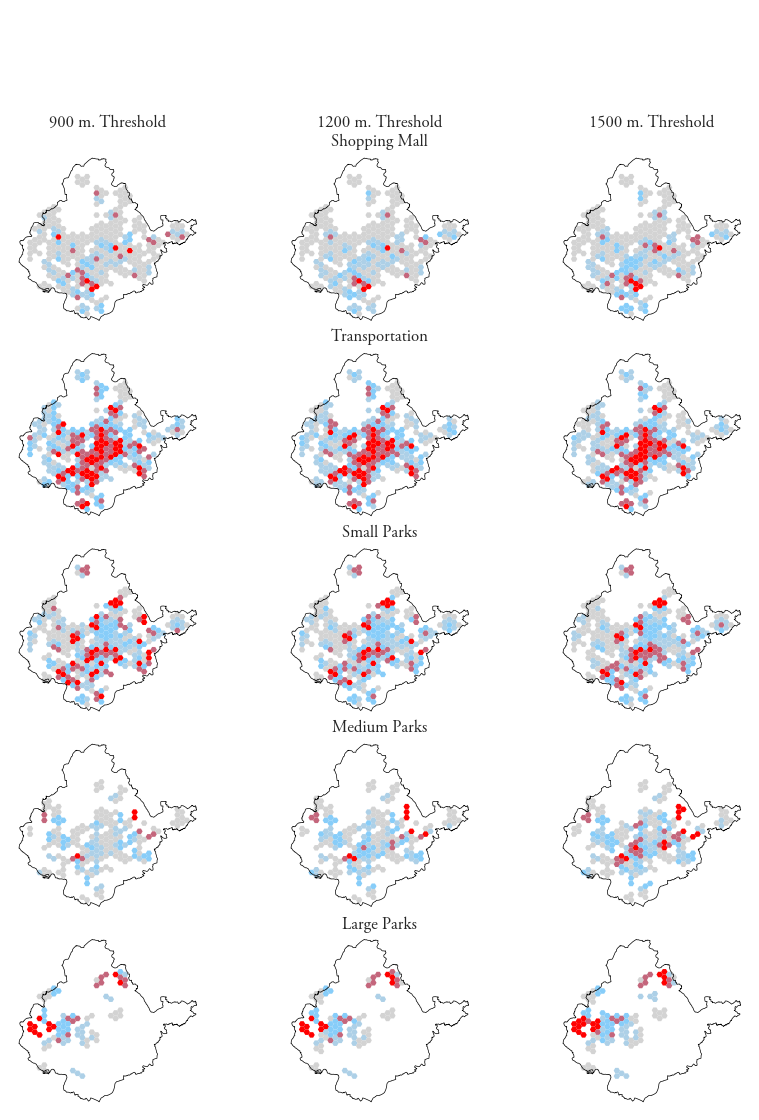

In [78]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)

fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title
make_plot(ax[0][0], df300c[~df300c['acc_shopping_mall'].isna()], 'acc_shopping_mall', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['acc_shopping_mall'].isna()], 'acc_shopping_mall', '1200 m. Threshold\nShopping Mall')
make_plot(ax[0][2], df900c[~df900c['acc_shopping_mall'].isna()], 'acc_shopping_mall', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['acc_transportation'].isna()], 'acc_transportation', '')
make_plot(ax[1][1], df600c[~df600c['acc_transportation'].isna()], 'acc_transportation', 'Transportation')
make_plot(ax[1][2], df900c[~df900c['acc_transportation'].isna()], 'acc_transportation', '')

make_plot(ax[2][0], df300c[~df300c['acc_parks_S'].isna()], 'acc_parks_S', '')
make_plot(ax[2][1], df600c[~df600c['acc_parks_S'].isna()], 'acc_parks_S', 'Small Parks')
make_plot(ax[2][2], df900c[~df900c['acc_parks_S'].isna()], 'acc_parks_S', '')

make_plot(ax[3][0], df300c[~df300c['acc_parks_M'].isna()], 'acc_parks_M', '')
make_plot(ax[3][1], df600c[~df600c['acc_parks_M'].isna()], 'acc_parks_M', 'Medium Parks')
make_plot(ax[3][2], df900c[~df900c['acc_parks_M'].isna()], 'acc_parks_M', '')

make_plot(ax[4][0], df300c[~df300c['acc_parks_L'].isna()], 'acc_parks_L', '')
make_plot(ax[4][1], df600c[~df600c['acc_parks_L'].isna()], 'acc_parks_L', 'Large Parks')
make_plot(ax[4][2], df900c[~df900c['acc_parks_L'].isna()], 'acc_parks_L', '')
fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/accessibility_factors_3.jpg")

plt.show()

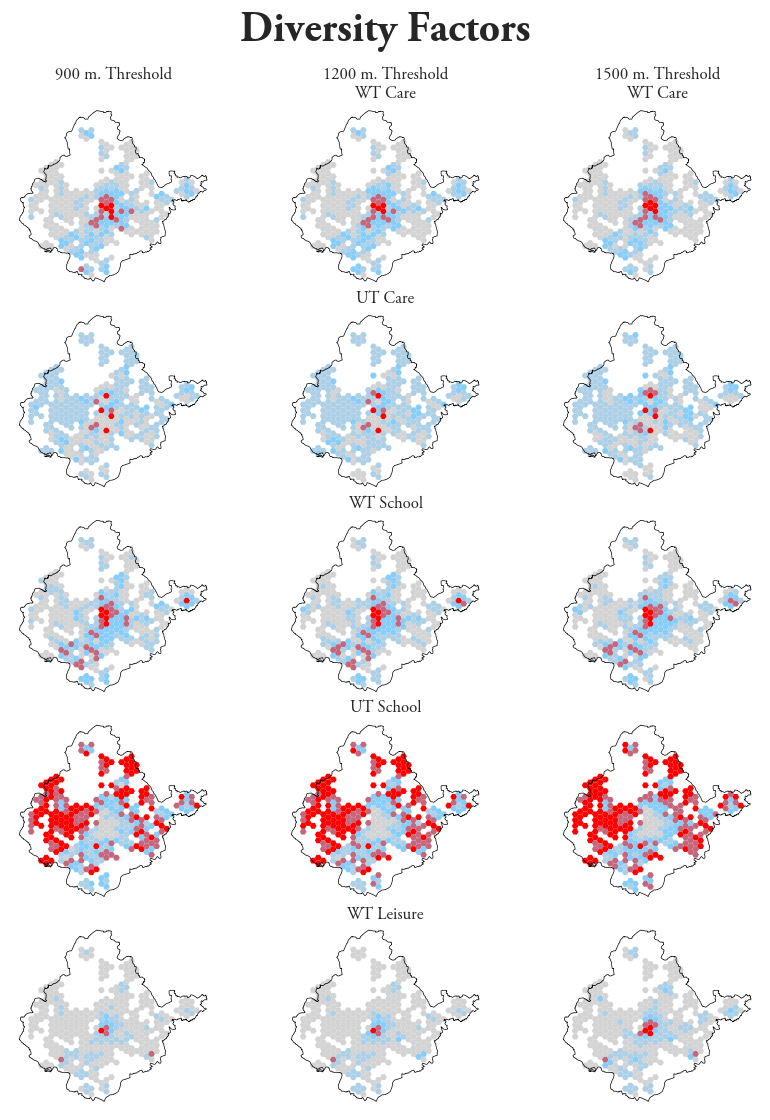

In [79]:
fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)

fig.suptitle('Diversity Factors',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['div_wt_care'].isna()], 'div_wt_care', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['div_wt_care'].isna()], 'div_wt_care', '1200 m. Threshold\nWT Care')
make_plot(ax[0][2], df900c[~df900c['div_wt_care'].isna()], 'div_wt_care', '1500 m. Threshold\nWT Care')

make_plot(ax[1][0], df300c[~df300c['div_ut_care'].isna()], 'div_ut_care', '')
make_plot(ax[1][1], df600c[~df600c['div_ut_care'].isna()], 'div_ut_care', 'UT Care')
make_plot(ax[1][2], df900c[~df900c['div_ut_care'].isna()], 'div_ut_care', '')

make_plot(ax[2][0], df300c[~df300c['div_wt_school'].isna()], 'div_wt_school', '')
make_plot(ax[2][1], df600c[~df600c['div_wt_school'].isna()], 'div_wt_school', 'WT School')
make_plot(ax[2][2], df900c[~df900c['div_wt_school'].isna()], 'div_wt_school', '')

make_plot(ax[3][0], df300c[~df300c['div_ut_school'].isna()], 'div_ut_school', '')
make_plot(ax[3][1], df600c[~df600c['div_ut_school'].isna()], 'div_ut_school', 'UT School')
make_plot(ax[3][2], df900c[~df900c['div_ut_school'].isna()], 'div_ut_school', '')

make_plot(ax[4][0], df300c[~df300c['div_wt_leisure'].isna()], 'div_wt_leisure', '')
make_plot(ax[4][1], df600c[~df600c['div_wt_leisure'].isna()], 'div_wt_leisure', 'WT Leisure')
make_plot(ax[4][2], df900c[~df900c['div_wt_leisure'].isna()], 'div_wt_leisure', '')

fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/diversity_factors_1.jpg")

plt.show()

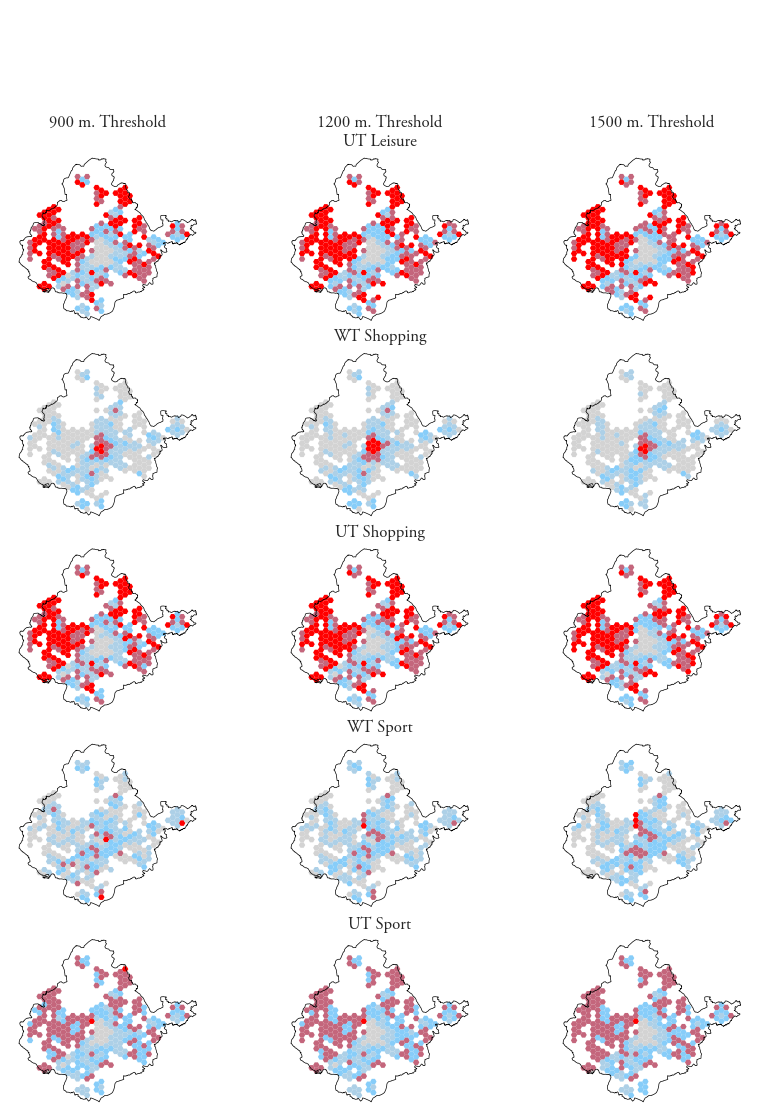

In [80]:
fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title
make_plot(ax[0][0], df300c[~df300c['div_ut_leisure'].isna()], 'div_ut_leisure', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['div_ut_leisure'].isna()], 'div_ut_leisure', '1200 m. Threshold\nUT Leisure')
make_plot(ax[0][2], df900c[~df900c['div_ut_leisure'].isna()], 'div_ut_leisure', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['div_wt_shopping'].isna()], 'div_wt_shopping', '')
make_plot(ax[1][1], df600c[~df600c['div_wt_shopping'].isna()], 'div_wt_shopping', 'WT Shopping')
make_plot(ax[1][2], df900c[~df900c['div_wt_shopping'].isna()], 'div_wt_shopping', '')

make_plot(ax[2][0], df300c[~df300c['div_ut_shopping'].isna()], 'div_ut_shopping', '')
make_plot(ax[2][1], df600c[~df600c['div_ut_shopping'].isna()], 'div_ut_shopping', 'UT Shopping')
make_plot(ax[2][2], df900c[~df900c['div_ut_shopping'].isna()], 'div_ut_shopping', '')

make_plot(ax[3][0], df300c[~df300c['div_wt_sport'].isna()], 'div_wt_sport', '')
make_plot(ax[3][1], df600c[~df600c['div_wt_sport'].isna()], 'div_wt_sport', 'WT Sport')
make_plot(ax[3][2], df900c[~df900c['div_wt_sport'].isna()], 'div_wt_sport', '')

make_plot(ax[4][0], df300c[~df300c['div_ut_sport'].isna()], 'div_ut_sport', '')
make_plot(ax[4][1], df600c[~df600c['div_ut_sport'].isna()], 'div_ut_sport', 'UT Sport')
make_plot(ax[4][2], df900c[~df900c['div_ut_sport'].isna()], 'div_ut_sport', '')

fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/diversity_factors_2.jpg")

plt.show()

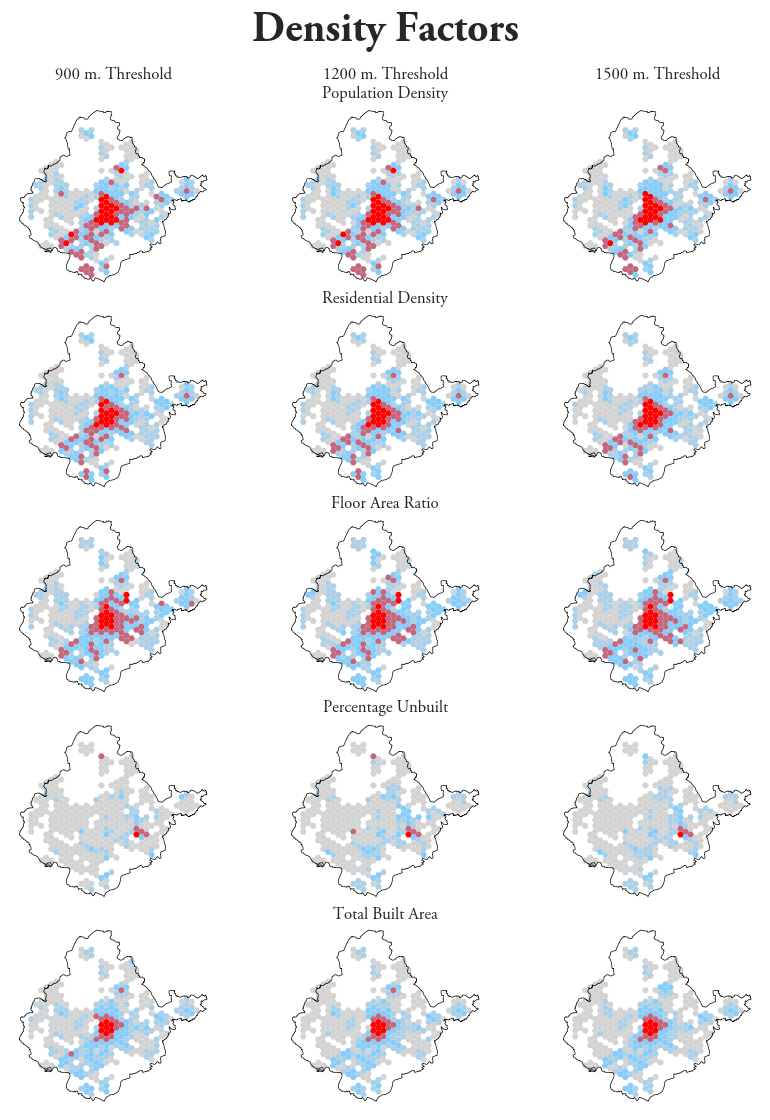

In [81]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('Density Factors',**csfont, fontweight="bold",y=1) # Title
make_plot(ax[0][0], df300c[~df300c['dens_pop_total'].isna()], 'dens_pop_total', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['dens_pop_total'].isna()], 'dens_pop_total', '1200 m. Threshold\nPopulation Density')
make_plot(ax[0][2], df900c[~df900c['dens_pop_total'].isna()], 'dens_pop_total', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['dens_hou_total'].isna()], 'dens_hou_total', '')
make_plot(ax[1][1], df600c[~df600c['dens_hou_total'].isna()], 'dens_hou_total', 'Residential Density')
make_plot(ax[1][2], df900c[~df900c['dens_hou_total'].isna()], 'dens_hou_total', '')

make_plot(ax[2][0], df300c[~df300c['dens_far'].isna()], 'dens_far', '')
make_plot(ax[2][1], df600c[~df600c['dens_far'].isna()], 'dens_far', 'Floor Area Ratio')
make_plot(ax[2][2], df900c[~df900c['dens_far'].isna()], 'dens_far', '')

make_plot(ax[3][0], df300c[~df300c['den_perc_unbuilt'].isna()], 'den_perc_unbuilt', '')
make_plot(ax[3][1], df600c[~df600c['den_perc_unbuilt'].isna()], 'den_perc_unbuilt', 'Percentage Unbuilt')
make_plot(ax[3][2], df900c[~df900c['den_perc_unbuilt'].isna()], 'den_perc_unbuilt', '')

make_plot(ax[4][0], df300c[~df300c['dens_built_total'].isna()], 'dens_built_total', '')
make_plot(ax[4][1], df600c[~df600c['dens_built_total'].isna()], 'dens_built_total', 'Total Built Area')
make_plot(ax[4][2], df900c[~df900c['dens_built_total'].isna()], 'dens_built_total', '')


fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/density_factors_1.jpg")

plt.show()

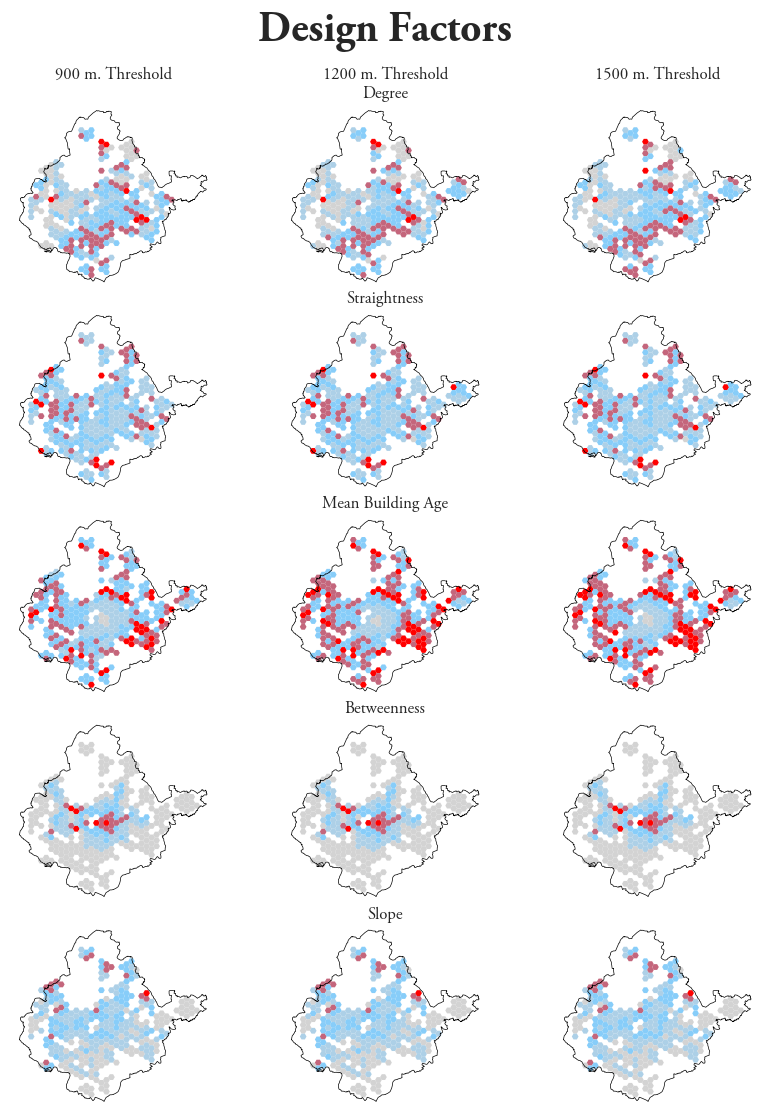

In [82]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('Design Factors',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['des_mean_degree'].isna()], 'des_mean_degree', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['des_mean_degree'].isna()], 'des_mean_degree', '1200 m. Threshold\nDegree')
make_plot(ax[0][2], df900c[~df900c['des_mean_degree'].isna()], 'des_mean_degree', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['des_straightness'].isna()], 'des_straightness', '')
make_plot(ax[1][1], df600c[~df600c['des_straightness'].isna()], 'des_straightness', 'Straightness')
make_plot(ax[1][2], df900c[~df900c['des_straightness'].isna()], 'des_straightness', '')

make_plot(ax[2][0], df300c[~df300c['des_building_age'].isna()], 'des_building_age', '')
make_plot(ax[2][1], df600c[~df600c['des_building_age'].isna()], 'des_building_age', 'Mean Building Age')
make_plot(ax[2][2], df900c[~df900c['des_building_age'].isna()], 'des_building_age', '')

make_plot(ax[3][0], df300c[~df300c['des_betweenness'].isna()], 'des_betweenness', '')
make_plot(ax[3][1], df600c[~df600c['des_betweenness'].isna()], 'des_betweenness', 'Betweenness')
make_plot(ax[3][2], df900c[~df900c['des_betweenness'].isna()], 'des_betweenness', '')

make_plot(ax[4][0], df300c[~df300c['des_slope'].isna()], 'des_slope', '')
make_plot(ax[4][1], df600c[~df600c['des_slope'].isna()], 'des_slope', 'Slope')
make_plot(ax[4][2], df900c[~df900c['des_slope'].isna()], 'des_slope', '')

fig.tight_layout(pad=0)

plt.savefig(r"../figures/design_factors_1.jpg")

plt.show()

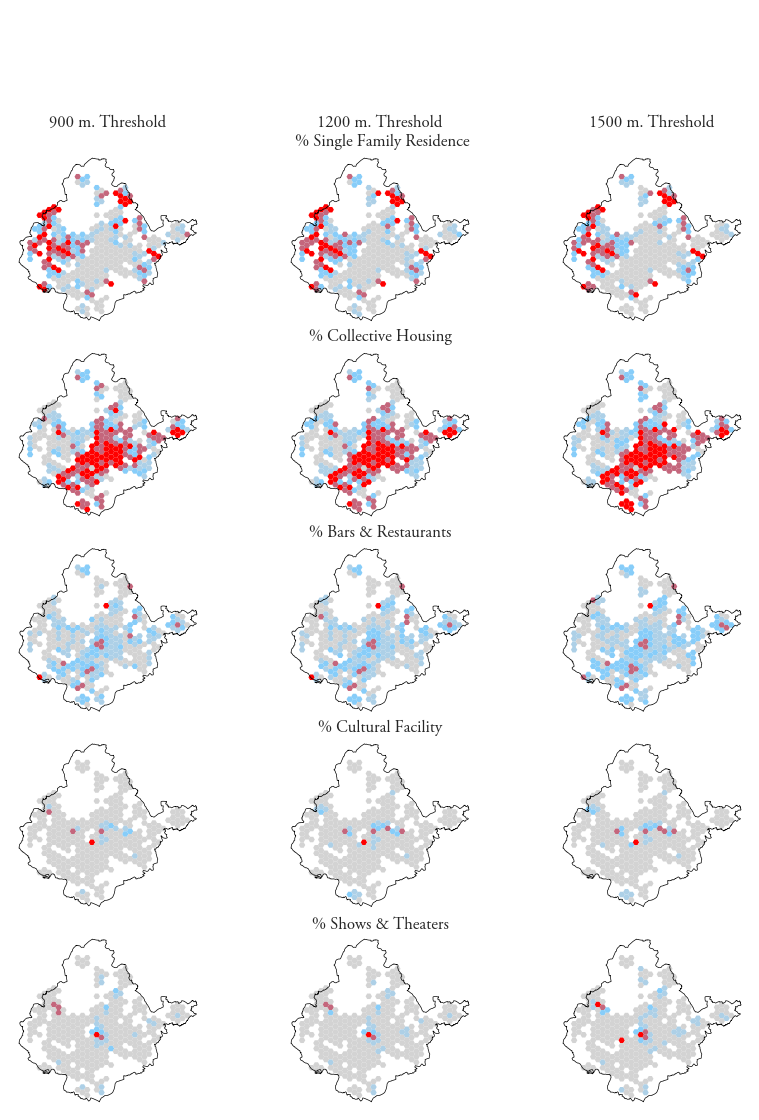

In [83]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['den_perc_housing_sfr'].isna()], 'den_perc_housing_sfr', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['den_perc_housing_sfr'].isna()], 'den_perc_housing_sfr', '1200 m. Threshold\n % Single Family Residence')
make_plot(ax[0][2], df900c[~df900c['den_perc_housing_sfr'].isna()], 'den_perc_housing_sfr', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['den_perc_housing_ch'].isna()], 'den_perc_housing_ch', '')
make_plot(ax[1][1], df600c[~df600c['den_perc_housing_ch'].isna()], 'den_perc_housing_ch', '% Collective Housing')
make_plot(ax[1][2], df900c[~df900c['den_perc_housing_ch'].isna()], 'den_perc_housing_ch', '')

make_plot(ax[2][0], df300c[~df300c['den_perc_leisure_bar'].isna()], 'den_perc_leisure_bar', '')
make_plot(ax[2][1], df600c[~df600c['den_perc_leisure_bar'].isna()], 'den_perc_leisure_bar', '% Bars & Restaurants')
make_plot(ax[2][2], df900c[~df900c['den_perc_leisure_bar'].isna()], 'den_perc_leisure_bar', '')

make_plot(ax[3][0], df300c[~df300c['den_perc_leisure_cultural'].isna()], 'den_perc_leisure_cultural', '')
make_plot(ax[3][1], df600c[~df600c['den_perc_leisure_cultural'].isna()], 'den_perc_leisure_cultural', '% Cultural Facility')
make_plot(ax[3][2], df900c[~df900c['den_perc_leisure_cultural'].isna()], 'den_perc_leisure_cultural', '')

make_plot(ax[4][0], df300c[~df300c['den_perc_leisure_shows'].isna()], 'den_perc_leisure_shows', '')
make_plot(ax[4][1], df600c[~df600c['den_perc_leisure_shows'].isna()], 'den_perc_leisure_shows', '% Shows & Theaters')
make_plot(ax[4][2], df900c[~df900c['den_perc_leisure_shows'].isna()], 'den_perc_leisure_shows', '')

fig.tight_layout(pad=0)

plt.savefig(r"../figures/density_factors_3.jpg")

plt.show()


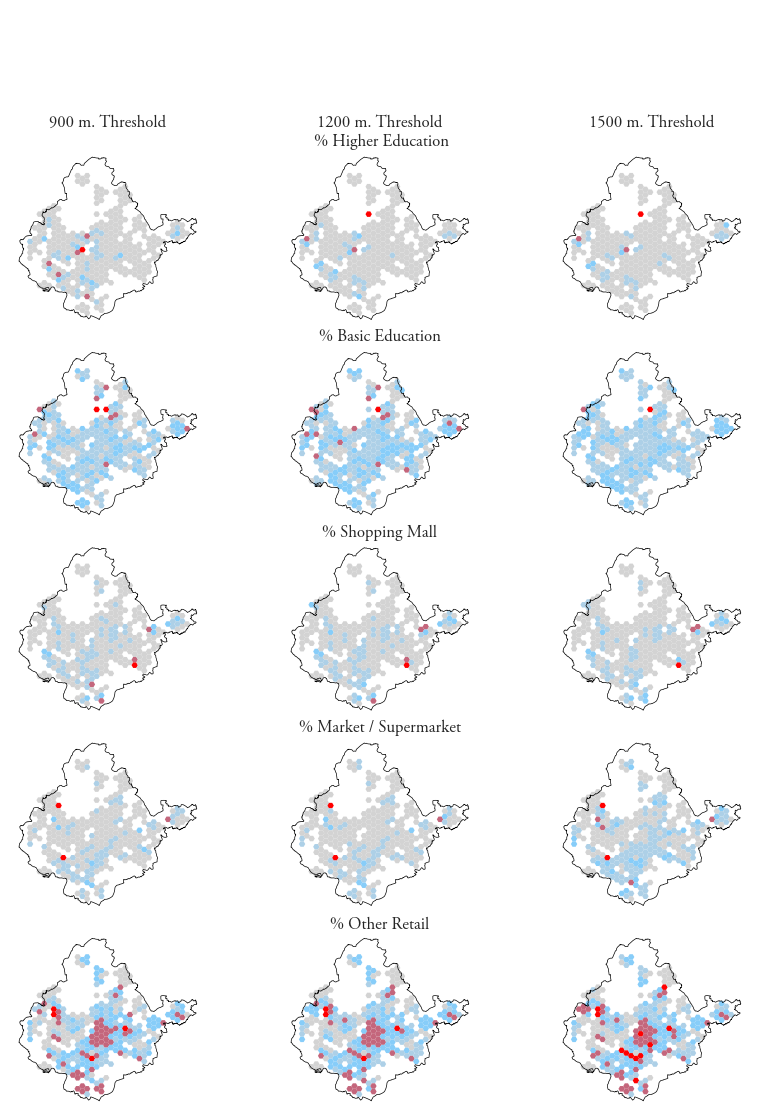

In [84]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['den_perc_school_superior'].isna()], 'den_perc_school_superior', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['den_perc_school_superior'].isna()], 'den_perc_school_superior', '1200 m. Threshold\n % Higher Education')
make_plot(ax[0][2], df900c[~df900c['den_perc_school_superior'].isna()], 'den_perc_school_superior', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['den_perc_school_basic'].isna()], 'den_perc_school_basic', '')
make_plot(ax[1][1], df600c[~df600c['den_perc_school_basic'].isna()], 'den_perc_school_basic', '% Basic Education')
make_plot(ax[1][2], df900c[~df900c['den_perc_school_basic'].isna()], 'den_perc_school_basic', '')

make_plot(ax[2][0], df300c[~df300c['den_perc_shopping_mall'].isna()], 'den_perc_shopping_mall', '')
make_plot(ax[2][1], df600c[~df600c['den_perc_shopping_mall'].isna()], 'den_perc_shopping_mall', '% Shopping Mall')
make_plot(ax[2][2], df900c[~df900c['den_perc_shopping_mall'].isna()], 'den_perc_shopping_mall', '')

make_plot(ax[3][0], df300c[~df300c['den_perc_shopping_market'].isna()], 'den_perc_shopping_market', '')
make_plot(ax[3][1], df600c[~df600c['den_perc_shopping_market'].isna()], 'den_perc_shopping_market', '% Market / Supermarket')
make_plot(ax[3][2], df900c[~df900c['den_perc_shopping_market'].isna()], 'den_perc_shopping_market', '')

make_plot(ax[4][0], df300c[~df300c['den_perc_shopping_alone'].isna()], 'den_perc_shopping_alone', '')
make_plot(ax[4][1], df600c[~df600c['den_perc_shopping_alone'].isna()], 'den_perc_shopping_alone', '% Other Retail')
make_plot(ax[4][2], df900c[~df900c['den_perc_shopping_alone'].isna()], 'den_perc_shopping_alone', '')

fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/density_factors_4.jpg")

plt.show()


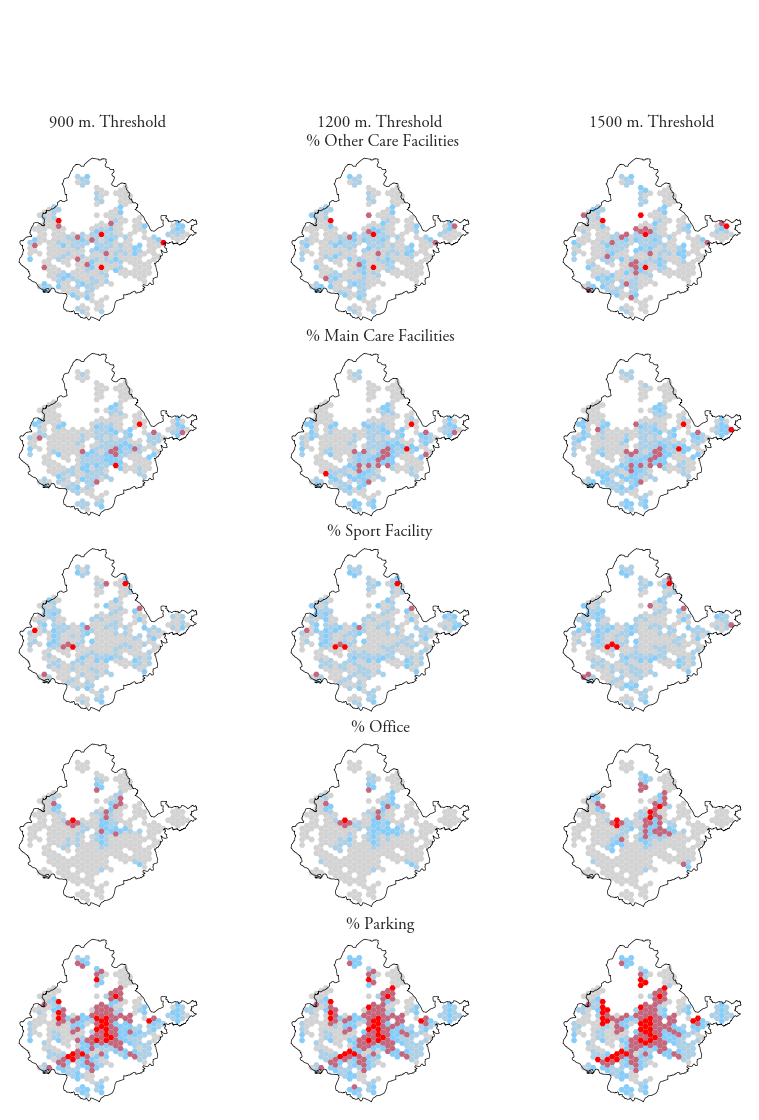

In [85]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['den_perc_care_other'].isna()], 'den_perc_care_other', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['den_perc_care_other'].isna()], 'den_perc_care_other', '1200 m. Threshold\n % Other Care Facilities')
make_plot(ax[0][2], df900c[~df900c['den_perc_care_other'].isna()], 'den_perc_care_other', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['den_perc_care_public'].isna()], 'den_perc_care_public', '')
make_plot(ax[1][1], df600c[~df600c['den_perc_care_public'].isna()], 'den_perc_care_public', '% Main Care Facilities')
make_plot(ax[1][2], df900c[~df900c['den_perc_care_public'].isna()], 'den_perc_care_public', '')

make_plot(ax[2][0], df300c[~df300c['den_perc_sport_other'].isna()], 'den_perc_sport_other', '')
make_plot(ax[2][1], df600c[~df600c['den_perc_sport_other'].isna()], 'den_perc_sport_other', '% Sport Facility')
make_plot(ax[2][2], df900c[~df900c['den_perc_sport_other'].isna()], 'den_perc_sport_other', '')

make_plot(ax[3][0], df300c[~df300c['den_perc_office'].isna()], 'den_perc_office', '')
make_plot(ax[3][1], df600c[~df600c['den_perc_office'].isna()], 'den_perc_office', '% Office')
make_plot(ax[3][2], df900c[~df900c['den_perc_office'].isna()], 'den_perc_office', '')

make_plot(ax[4][0], df300c[~df300c['den_perc_parking'].isna()], 'den_perc_parking', '')
make_plot(ax[4][1], df600c[~df600c['den_perc_parking'].isna()], 'den_perc_parking', '% Parking')
make_plot(ax[4][2], df900c[~df900c['den_perc_parking'].isna()], 'den_perc_parking', '')

fig.tight_layout(pad=0)
#plt.grid(False)

plt.savefig(r"../figures/density_factors_5.jpg")

plt.show()

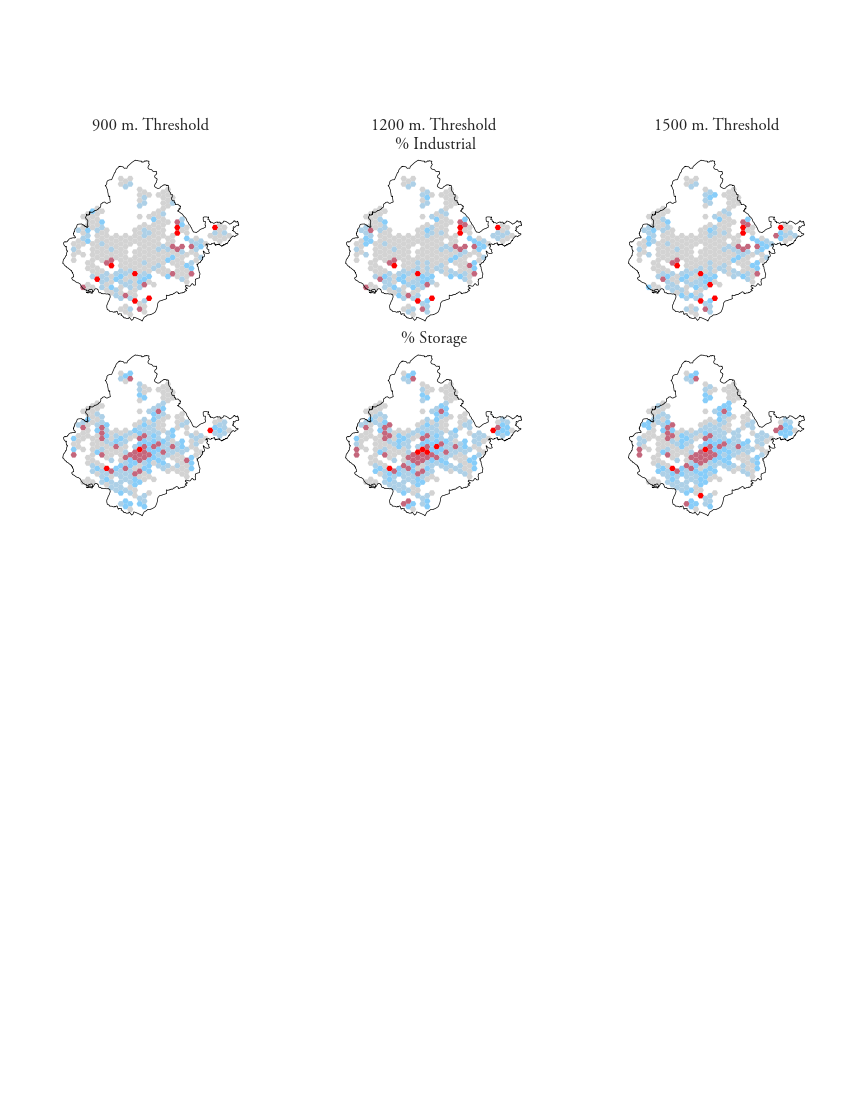

In [86]:

fig, ax = plt.subplots(5,3,figsize=(8.5,11),sharey=True,sharex=True)
fig.suptitle('\n',**csfont, fontweight="bold",y=1) # Title

make_plot(ax[0][0], df300c[~df300c['den_perc_industrial'].isna()], 'den_perc_industrial', '900 m. Threshold\n')
make_plot(ax[0][1], df600c[~df600c['den_perc_industrial'].isna()], 'den_perc_industrial', '1200 m. Threshold\n % Industrial')
make_plot(ax[0][2], df900c[~df900c['den_perc_industrial'].isna()], 'den_perc_industrial', '1500 m. Threshold\n')

make_plot(ax[1][0], df300c[~df300c['den_perc_storage'].isna()], 'den_perc_storage', '')
make_plot(ax[1][1], df600c[~df600c['den_perc_storage'].isna()], 'den_perc_storage', '% Storage')
make_plot(ax[1][2], df900c[~df900c['den_perc_storage'].isna()], 'den_perc_storage', '')

for x in (2, 3,4):
    for y in (0,1,2):
        ax[x][y].yaxis.set_label_text("")
        ax[x][y].set_xlabel('') 
        ax[x][y].axis('off')

fig.tight_layout(pad=0.1)

plt.savefig(r"../figures/density_factors_6.jpg")

plt.show()

